# Exercise 1

### Data-Driven Demand Learning and Dynamic Pricing Strategies in Competitive Markets
https://hpi.de/plattner/teaching/summer-term-2018/data-driven-demand-learning-and-dynamic-pricing-strategies.html

In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

seed = 17*17
np.random.seed(seed)
random.seed(seed)

In [2]:
K = 5                     # number of players
TT = 100                  # time horizon
M = TT + 100              # number of market reaction events. we create more event than the
                          # horizon since we might end up short of 100 (e.g., avg of uniforms = 0.945)

cc = 1;                   # mittlerer Abstand zwischen Kunden arrivals
C = int(TT / cc + 100)    # number of customer events

### Simulation Parameters (wann Kunden kommen und Firmen adjusten)

In [3]:
Dk = np.random.uniform(0.8, 1.2, (M, K))     # time between price adjustments of firm k
tk = Dk                                       # time of adjustments of firm k
tk[0,:] = np.random.uniform(0, 1, K)
for m in range(1, M):
    for k in range(K):
        tk[m, k] = tk[m - 1, k] + Dk[m, k]

AT = tk.ravel()                               # set of price adjustments of all firms before time horizon TT
AT = np.sort(np.unique(np.append(AT[AT<TT], 100)))

NAT = len(AT)                                 # number of adjustment times

# param tm   {i in 0..NAT} := if i=0 or i>NAT then 0 else member(i,AT);  # Zeitpunkt der i-ten Preisanpassung
tm = [0] * (NAT + 1)                          # Zeitpunkt der i-ten Preisanpassung
for i in range(NAT):
    tm[i + 1] = AT[i]
DM = [0] * NAT                                 # time between adjustment events
for i in range(NAT):
    DM[i] = tm[i+1] - tm[i]

DC = np.random.exponential(size=C) * cc             # waitung time between customer arrivals
tc =[-1] * C                                        # Zeitpunkt des Ankommens des c-ten Kundens
for i in range(1, C):
    tc[i] = tc[i - 1] + DC[i]

# param ZM   {i in 1..NAT} := min{k in 1..K:sum{j in 1..M:tk[j,k]=tm[i]}1 = 1} k; 
ZM = [0] * NAT                                   # firm k die beim i-ten Gesamtadjust adjusted
for i, t in enumerate(tm):
    res = np.where(tk == t)
    if len(res[1]) > 0:
        ZM[i] = res[1][0]

SC = np.zeros(shape=(C, K))                      # paraemter for customer c scoring of firm k
Zq = np.random.uniform(size = C)                 # customer c random scoring weight for quality
# Zq = np.ones((C,), dtype=int)                  # helper for debugging
Zr = np.random.uniform(0, 0.2, size = C)         # customer c random scoring weight for rating

ZC = np.zeros(C, dtype=int)                      # for decision of customer c

**A few plots**

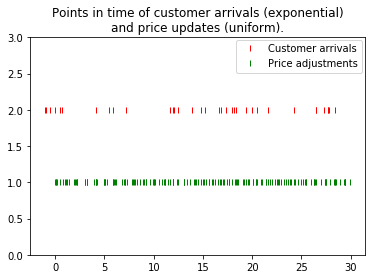

In [4]:
tc_plot = np.array(tc)
tm_plot = np.array(tm)
plot_limit = 30
plt.plot(tc_plot[tc_plot<plot_limit],[2 for _ in tc_plot[tc_plot<plot_limit]],'r|', label='Customer arrivals')
plt.plot(tm_plot[tm_plot<plot_limit],[1 for _ in tm_plot[tm_plot<plot_limit]],'g|', label='Price adjustments')
plt.legend(bbox_to_anchor=(0.99, 0.99), loc=1, borderaxespad=0.)
axes = plt.gca()
plt.title('Points in time of customer arrivals (exponential)\nand price updates (uniform).')
axes.set_ylim([0.0, 3.0])
plt.show()

### Aktuelle Marktsituation

In [5]:
p = np.round(np.random.uniform(6, 16, size = K))                    # current prices competitors
q = np.round(np.random.uniform(0.5, 5.5, size = K))                 # current quality competitors
r = np.round(np.random.uniform(90, 100, size = K), decimals = 1)    # current prices competitors

# q = np.ones((K,), dtype=int)                                      # helper for debugging

### Hilfsparameter zur Aufzeichnung der Simulation

In [6]:
T = 0                                                         # current time in process

count = 0                                                     # zaehler fuer adjustments of firm 1
F = 0                                                         # betrachtete Firm (obda firm 1)

B = sum([1 if ZM[i] == F else 0 for i in range(NAT - 1)])     # Anzahl der adjustments of firm 1

tb = np.zeros(B + 1)                                          # Zeit der adjustments of firm 1
db = [tb[i] - tb[i-1] for i in range(1, B)]                   # Zeit zwischen adjustments of firm 1
y  = np.zeros(B + 1)                                          # anzahl verkaeufe von firm 1 zwischen adjustments

price  = np.full((1, B + 1), p[F])                            # our Angebotspreis
quali  = np.full((1, B + 1), q[F])                            # our quality
rating = np.full((1, B + 1), r[F])                            # our rating

pcomp = np.zeros(1)                                           # Preise competitor
qcomp = np.zeros(1)                                           # quality competitor
rcomp = np.zeros(1)                                           # rating competitor

G = np.zeros(K)                                               # profit of all firms

G_acc = np.zeros(shape=(NAT, K))                              # accumulated profit of all firms
p_history = np.zeros(shape=(NAT, K))                          # storing prices over time

# Simulation

In [7]:
print("   t               \t   p1    G1         p2   G2            p3   G3")
for i in range(NAT): # gehe M market situations durch, getrennt durch einzelne firm adjustments
    for c in range(C):
        # betrachte ankommende Kunden zwischen firm adjustments
        if not (tm[i] <= tc[c] < tm[i+1]):
            continue

        for k in range(K):
            # Scoring Berechnung für jedes aktuelle Angebot
            SC[c, k] = p[k] + Zq[c] * q[k] + Zr[c] * (100 - r[k])

        if np.min(SC[c,]) < random.randint(5, 16):  # willingness-to-pay des Kunden gross genug?
            scores = list(SC[c,])
            ZC[c] = scores.index(min(scores))

            # profit accumulation for firm ZC[c] that sells to customer c  
            G[ZC[c]] += p[ZC[c]]
        
        # TODO exercise 2: store all 'relevant' information generated here,
        # that might be of interest for you learning

    G_acc[i, ] = G

    T += DM[i]
    if T < 100:   # Ausgabe der Simulations-Events bis T=100
        cust_cnt = sum([1 if tm[i] <= tc[c] < tm[i+1] else 0 for c in range(C)])
        did_customer_arrive = ' '
        if cust_cnt > 0:
            did_customer_arrive = '-'
        print("\n {:5.2f} - {:5.2f} {}:\t".format(tm[i], tm[i+1], did_customer_arrive), end='')
        for k in range(K):
            sale_cnt = sum([1 if ((tm[i] <= tc[c] < tm[i+1]) and k == ZC[c]) else 0 for c in range(C)])
            merchant_sold = ' '
            if sale_cnt > 0:
                merchant_sold = str('*' * sale_cnt)
            print("{:>3}{:5.1f} ({:6.2f})  ".format(merchant_sold, p[k], G[k]/T), end='')

                                               
    if T < TT:  # Preisanpassungen der Firmen (je nach dem wer dran ist)
        price = 0.0

        if ZM[i] == 0:    # strategy firm 1
            if random.random() < 0.1:
                price = round(random.random() * 15, 2)
            else:
                # 0% Anteil price exploration
                if p[ZM[i]] < 5:
                    price = 10
                else:
                    merchs = set([k for k in range(K)])
                    merchs.remove(ZM[i]) # all merchants without the currently adjusting
                    price = min([max(4.9, p[k]-0.5) for k in merchs])
        elif ZM[i] == 1:      # strategy firm 2
            if p[ZM[i]] < 4:
                price = 9
            else:
                merchs = set([k for k in range(K)])
                merchs.remove(ZM[i]) # all merchants without the currently adjusting
                price = min([max(3.9, p[k]-0.5) for k in merchs])
        elif ZM[i] == 2:      # strategy firm 3
            if p[ZM[i]] < 6:
                price = 12
            else:
                merchs = set([k for k in range(K)])
                merchs.remove(ZM[i]) # all merchants without the currently adjusting
                price = min([max(5.9, p[k]-0.5) for k in merchs])
        elif ZM[i] == 3:      # strategy firm 4
            price = 11
        else:                 # strategy firm 5
            price = 13

        p[ZM[i]] = price

    p_history[i, ] = p

   t               	   p1    G1         p2   G2            p3   G3

  0.00 -  0.03  :	     9.0 (  0.00)      14.0 (  0.00)      10.0 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.03 -  0.09  :	     7.5 (  0.00)      14.0 (  0.00)      10.0 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.09 -  0.20  :	     7.5 (  0.00)      14.0 (  0.00)       7.0 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.20 -  0.50 -:	     7.5 (  0.00)       6.5 (  0.00)    *  7.0 ( 14.13)       8.0 (  0.00)      16.0 (  0.00)  
  0.50 -  0.83 -:	  *  6.0 (  0.00)       6.5 (  0.00)       7.0 (  8.39)       8.0 (  0.00)      16.0 (  0.00)  
  0.83 -  1.00  :	     6.0 (  0.00)       6.5 (  0.00)       7.0 (  6.99)      11.0 (  0.00)      16.0 (  0.00)  
  1.00 -  1.06  :	     6.0 (  0.00)       6.5 (  0.00)       7.0 (  6.63)      11.0 (  0.00)      13.0 (  0.00)  
  1.06 -  1.19  :	     6.0 (  0.00)       6.5 (  0.00)       5.9 (  5.90)      11.0 (  0.00)      13.0 (  0.00)  
  1.19 -  1.35  :	  

 44.26 - 44.47  :	    10.0 (  0.11)       5.4 (  2.22)       5.9 (  1.38)      11.0 (  0.00)      13.0 (  0.00)  
 44.47 - 44.54  :	     4.9 (  0.11)       5.4 (  2.22)       5.9 (  1.38)      11.0 (  0.00)      13.0 (  0.00)  
 44.54 - 44.67  :	     4.9 (  0.11)       5.4 (  2.21)      12.0 (  1.37)      11.0 (  0.00)      13.0 (  0.00)  
 44.67 - 44.71  :	     4.9 (  0.11)       5.4 (  2.21)      12.0 (  1.37)      11.0 (  0.00)      13.0 (  0.00)  
 44.71 - 45.23  :	     4.9 (  0.11)       4.4 (  2.18)      12.0 (  1.36)      11.0 (  0.00)      13.0 (  0.00)  
 45.23 - 45.41  :	     4.9 (  0.11)       4.4 (  2.17)      12.0 (  1.35)      11.0 (  0.00)      13.0 (  0.00)  
 45.41 - 45.47  :	    10.0 (  0.11)       4.4 (  2.17)      12.0 (  1.35)      11.0 (  0.00)      13.0 (  0.00)  
 45.47 - 45.53 -:	    10.0 (  0.11)   **  4.4 (  2.36)      12.0 (  1.35)      11.0 (  0.00)      13.0 (  0.00)  
 45.53 - 45.64  :	    10.0 (  0.11)       4.4 (  2.36)       5.9 (  1.34)      11.0 (  0

 77.89 - 77.97  :	    10.0 (  0.13)       5.4 (  2.31)       5.9 (  1.82)      11.0 (  0.00)      13.0 (  0.00)  
 77.97 - 78.04  :	    10.0 (  0.13)       5.4 (  2.31)       5.9 (  1.81)      11.0 (  0.00)      13.0 (  0.00)  
 78.04 - 78.50 -:	    10.0 (  0.13)       5.4 (  2.30)    *  5.9 (  1.88)      11.0 (  0.00)      13.0 (  0.00)  
 78.50 - 78.72  :	     4.9 (  0.13)       5.4 (  2.29)       5.9 (  1.87)      11.0 (  0.00)      13.0 (  0.00)  
 78.72 - 78.86  :	     4.9 (  0.13)       5.4 (  2.29)      12.0 (  1.87)      11.0 (  0.00)      13.0 (  0.00)  
 78.86 - 79.02  :	     4.9 (  0.13)       4.4 (  2.28)      12.0 (  1.87)      11.0 (  0.00)      13.0 (  0.00)  
 79.02 - 79.12  :	     4.9 (  0.13)       4.4 (  2.28)      12.0 (  1.86)      11.0 (  0.00)      13.0 (  0.00)  
 79.12 - 79.44  :	     4.9 (  0.13)       4.4 (  2.27)      12.0 (  1.86)      11.0 (  0.00)      13.0 (  0.00)  
 79.44 - 79.58  :	    10.0 (  0.13)       4.4 (  2.27)      12.0 (  1.85)      11.0 (  0

Assigned static qualities for merchants: [4, 2, 1, 5, 5]


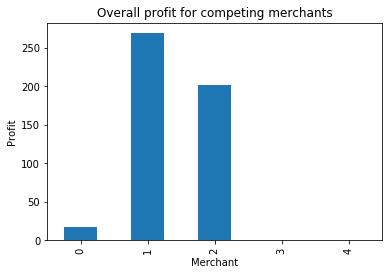

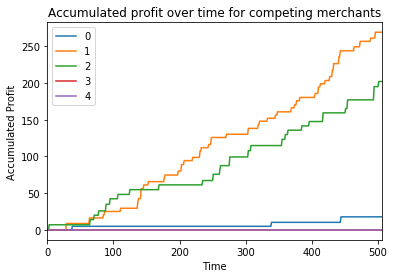

In [8]:
%matplotlib inline
# %matplotlib notebook

plt_profit = pd.DataFrame(G).plot(kind='bar')
plt_profit.set_title("Overall profit for competing merchants")
plt_profit.set_ylabel("Profit")
plt_profit.set_xlabel("Merchant")
plt_profit.legend_.remove()

plt_acc_profit = pd.DataFrame(G_acc).plot()
plt_acc_profit.set_ylabel("Accumulated Profit")
plt_acc_profit.set_xlabel("Time")
plt_acc_profit.set_title("Accumulated profit over time for competing merchants")

print(f'Assigned static qualities for merchants: {list(map(int, q))}')

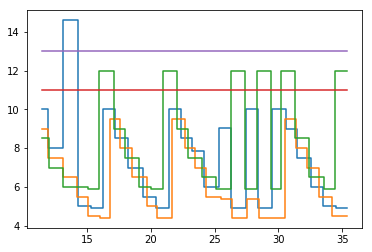

In [9]:
# %matplotlib notebook

for k in range(K):
    plt.step(tm[60:180], p_history[60-1:180-1, k]) # len(tm) == 1 + len(p_hist)
    # selecting 40-180 since it shows nice trajectories
plt.legend()
plt.show()

# Demand Learning

In [10]:
# TODO exercise 2: create a vector that stores the sales of a given merchant
#                  (and only these) in a binary vector (for now, apply min(1,v))
# TODO exercise 2: Create feature vectors as shown in the lecture.
# TODO exercise 2: Use sklearn.linear_model.LogisticRegression to estimate the sales probabilities

In [11]:
# TODO exercise 2: plot two graphs
                  # (i)  a graph showing the probabilities to sell (y-axis) with
                  #     varying own prices (x-axis) for a given situation 
                  # (ii) a graph showing the expected profit (y-axis) with
                  #     varying own prices (x-axis) for a given situation
# As the given situation, consider five merchants (own rating = 90, own quality = 2):
    # (i)   price = 8,    rating = 95, quality = 2
    # (ii)  price = 10,   rating = 85, quality = 3
    # (iii) price = 12,   rating = 80, quality = 1
    # (iv)  price = 8.05, rating = 99, quality = 4
    # (v)   price = 9.9,  rating = 70, quality = 2

In [12]:
# TODO exercise 2  - BONUS: calculate LL, AIC, and McFadden Pseudo R-squared